In [1]:
import os
import numpy as np
import bayesflow as bf
from matplotlib import pyplot as plt

HOME = os.getenv("HOME")
RNG = np.random.default_rng(2023)

/Users/alisamar/Desktop/cell_migration_bayesflow/.venv/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
def prior_fun(D=4):
    return RNG.normal(size=D)

prior = bf.simulation.Prior(prior_fun=prior_fun)
prior(batch_size=10)

{'prior_draws': array([[ 0.60172129,  1.15161897, -1.35946236,  0.22205533],
        [-0.77586755,  0.8087058 , -0.19862826, -1.57869386],
        [-0.6292893 , -0.38775694,  0.05018619, -0.90704364],
        [ 0.13213809,  1.40490249,  0.40410205, -1.03741343],
        [-0.74180264,  1.26349944, -0.68932403,  0.70801477],
        [-0.03504752, -0.83781649, -0.73251795,  1.04738251],
        [-1.4238012 ,  1.35404102, -0.39509257, -0.92921568],
        [ 0.44406269,  0.14221762,  1.36874071, -0.49876242],
        [-0.0742687 ,  0.93937197, -0.62614275, -1.02895874],
        [-2.13303915,  0.90438789, -2.08440387,  0.28253568]]),
 'batchable_context': None,
 'non_batchable_context': None}

In [3]:
def likelihood_fun(params, n_obs=50):
    return RNG.normal(loc=params, size=(n_obs, params.shape[0]))

simulator = bf.simulation.Simulator(simulator_fun=likelihood_fun)

In [4]:
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 50, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [5]:
out = model(batch_size=3)
print(list(out.keys()))

['prior_non_batchable_context', 'prior_batchable_context', 'prior_draws', 'sim_non_batchable_context', 'sim_batchable_context', 'sim_data']


In [6]:
print("Shape of sim_data: ", out["sim_data"].shape)

Shape of sim_data:  (3, 50, 4)


In [7]:
summary_net = bf.networks.DeepSet(summary_dim=10)

In [9]:
test_inp = model(batch_size=3)
summary_rep = summary_net(test_inp["sim_data"]).numpy()

print("Shape of simulated data sets: ", test_inp["sim_data"].shape)
print("Shape of summary vectors: ", summary_rep.shape)


Shape of simulated data sets:  (3, 50, 4)
Shape of summary vectors:  (3, 10)


In [10]:
inference_net = bf.networks.InvertibleNetwork(
    num_params=4,
    num_coupling_layers=4,
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False},
)

In [11]:
z, log_det_J = inference_net(test_inp["prior_draws"], summary_rep)

In [12]:
print("Shape of latent variables:", z.numpy().shape)
print("Shape of log det Jacobian:", log_det_J.numpy().shape)

Shape of latent variables: (3, 4)
Shape of log det Jacobian: (3,)


In [13]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

In [14]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [15]:
out = model(3)
print("Keys of simulated dict: ", list(out.keys()))

Keys of simulated dict:  ['prior_non_batchable_context', 'prior_batchable_context', 'prior_draws', 'sim_non_batchable_context', 'sim_batchable_context', 'sim_data']


In [16]:
conf_out = trainer.configurator(out)
print("Keys of configured dict: ", list(conf_out.keys()))

Keys of configured dict:  ['summary_conditions', 'direct_conditions', 'parameters']


In [17]:
print(np.allclose(out["sim_data"], conf_out["summary_conditions"]))
print(np.allclose(out["prior_draws"], conf_out["parameters"]))

True
True


In [18]:
_ = model(32)

In [19]:
history = trainer.train_online(epochs=10, iterations_per_epoch=1000, batch_size=32, validation_sims=200)

INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 1000/1000 [00:14<00:00, 70.34it/s, Epoch: 1, Iter: 1000,Loss: -1.264,Avg.Loss: 1.003,LR: 4.88E-04]
INFO:root:Validation, Epoch: 1, Loss: -0.860
Training epoch 2: 100%|██████████| 1000/1000 [00:10<00:00, 99.19it/s, Epoch: 2, Iter: 1000,Loss: -1.722,Avg.Loss: -1.253,LR: 4.52E-04]
INFO:root:Validation, Epoch: 2, Loss: -1.710
Training epoch 3: 100%|██████████| 1000/1000 [00:10<00:00, 99.47it/s, Epoch: 3, Iter: 1000,Loss: -1.700,Avg.Loss: -1.539,LR: 3.97E-04]
INFO:root:Validation, Epoch: 3, Loss: -1.801
Training epoch 4: 100%|██████████| 1000/1000 [00:10<00:00, 99.65it/s, Epoch: 4, Iter: 1000,Loss: -1.935,Avg.Loss: -1.732,LR: 3.27E-04]
INFO:root:Validation, Epoch: 4, Loss: -1.846
Training epoch 5: 100%|██████████| 1000/1000 [00:09<00:00, 100.43it/s, Epoch: 5, Iter: 1000,Loss: -1.807,Avg.Loss: -1.854,LR: 2.50E-04]
INFO:root:Validation, Epoch: 5, Loss: -1.853
Training epoch 6: 100%|██████████| 1000/1000 [00

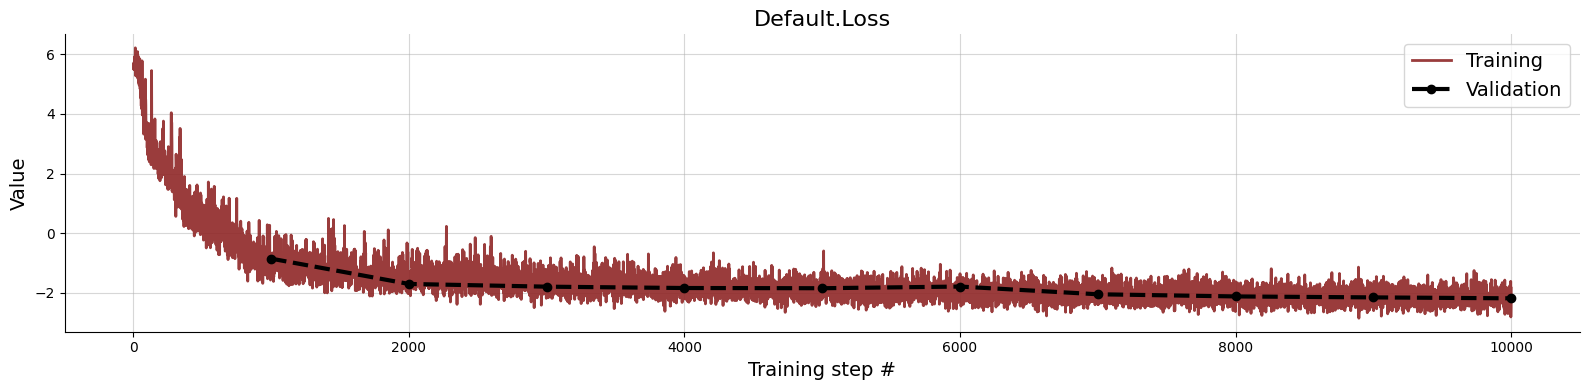

In [21]:
f = bf.diagnostics.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)

In [23]:
test_sims = trainer.configurator(model(500))

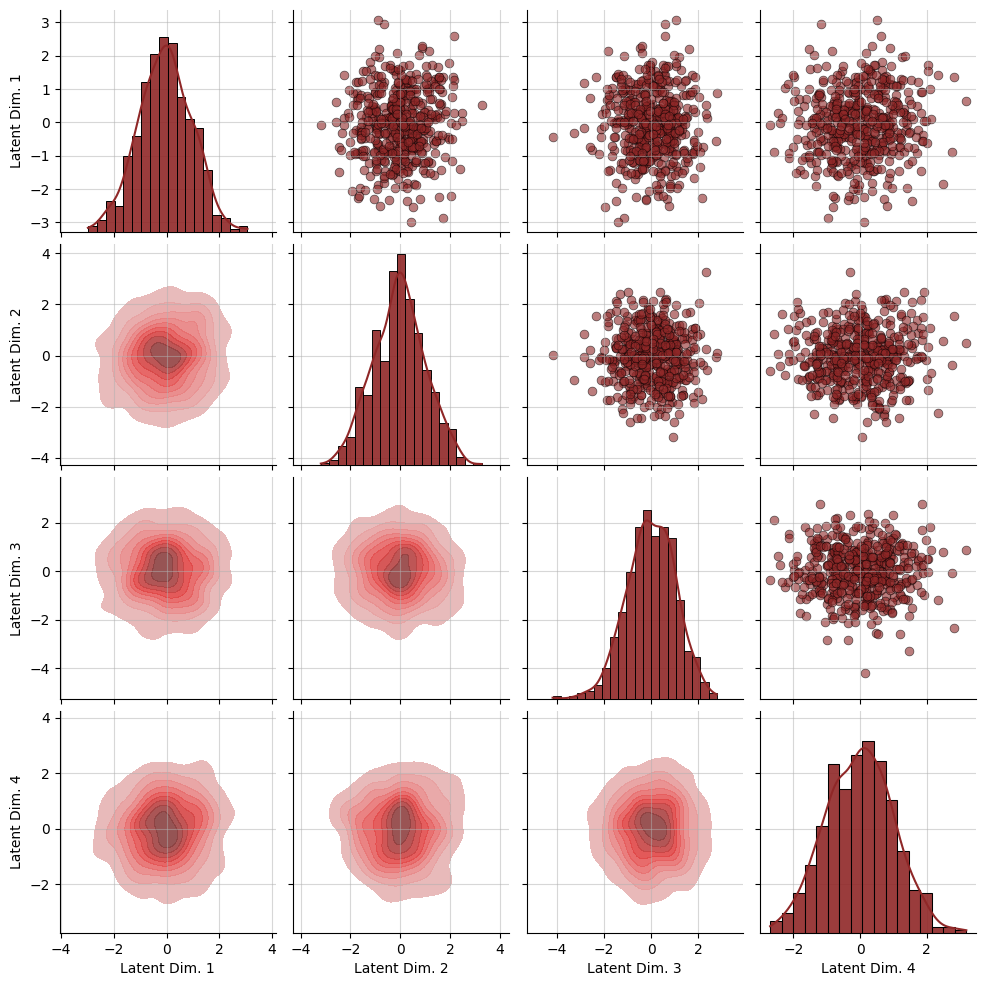

In [24]:
z_samples, _ = amortizer(test_sims)
f = bf.diagnostics.plot_latent_space_2d(z_samples)

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 5.                    Confidence intervals might be unreliable!


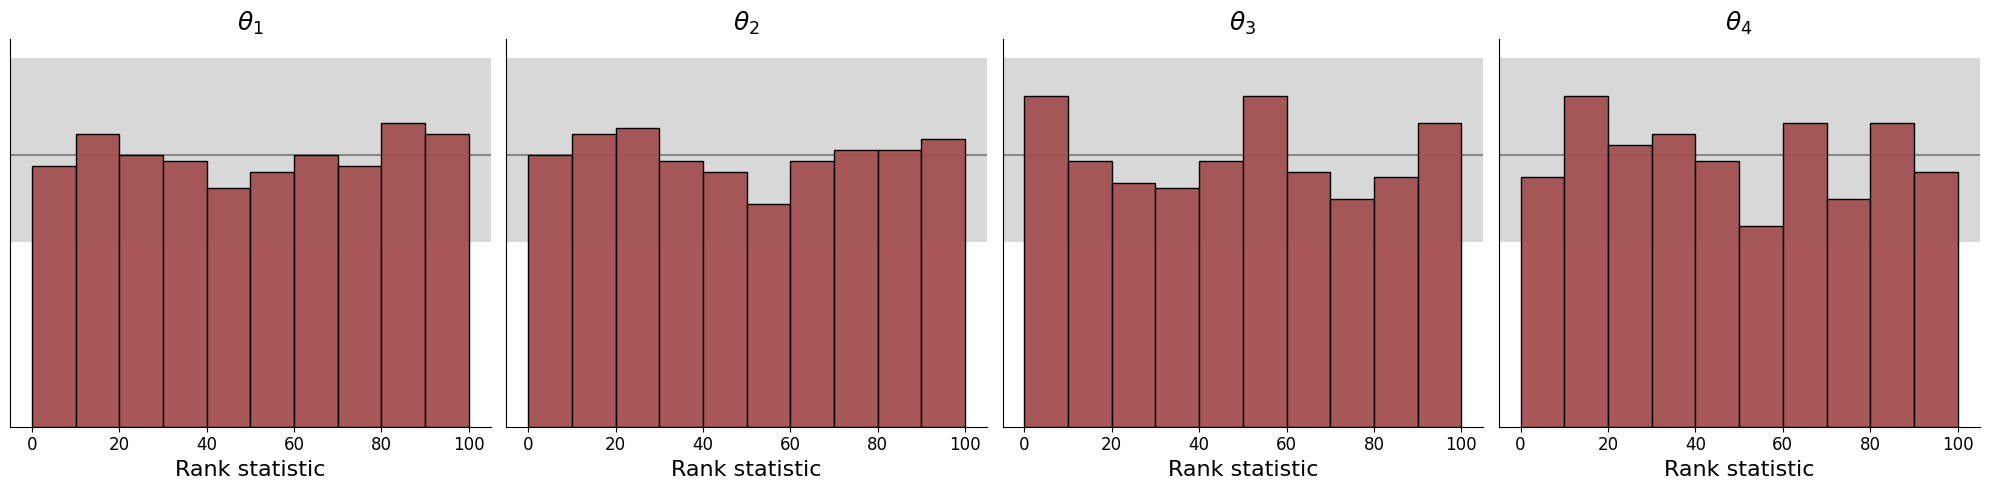

In [25]:
# Obtain 100 posterior samples for each simulated data set in test_sims
posterior_samples = amortizer.sample(test_sims, n_samples=100)
f = bf.diagnostics.plot_sbc_histograms(posterior_samples, test_sims["parameters"], num_bins=10)

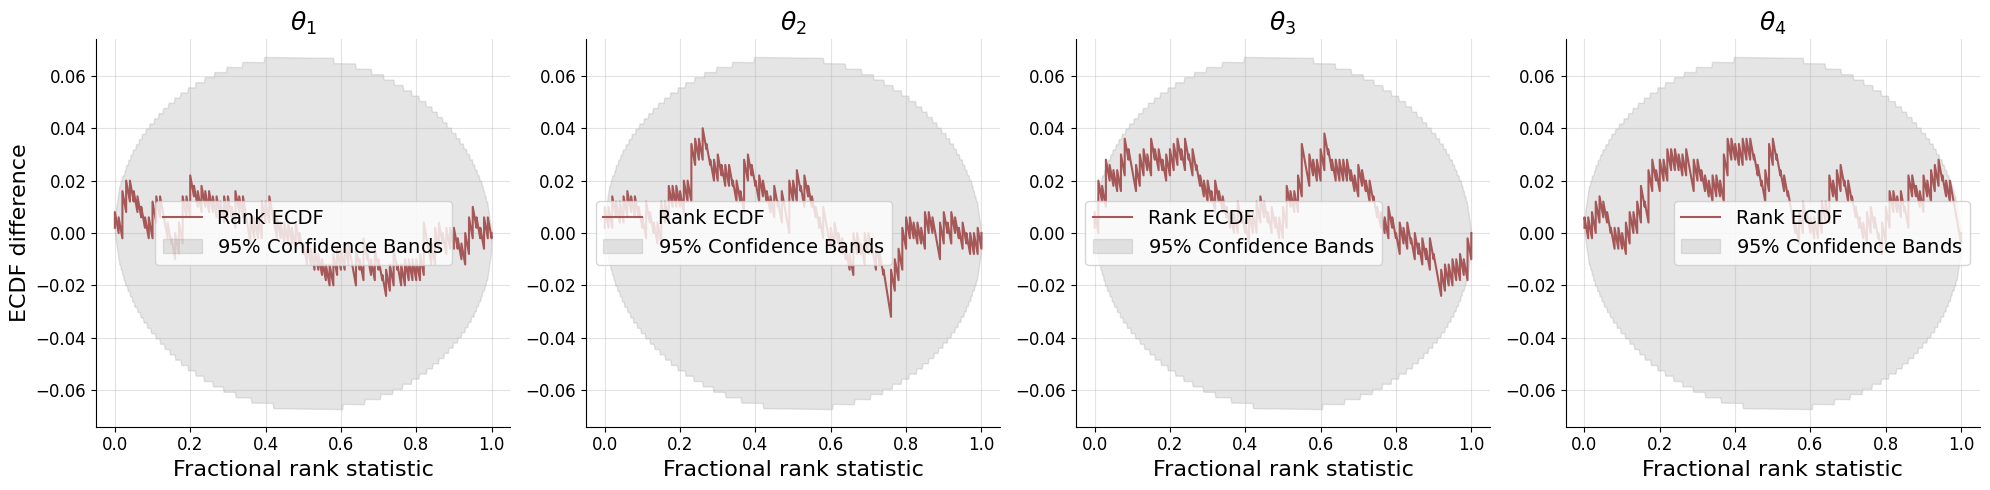

In [26]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, test_sims["parameters"], difference=True)

In [27]:
post_samples = amortizer.sample(test_sims, n_samples=1000)

Shape of posterior samples array: (500, 1000, 4)


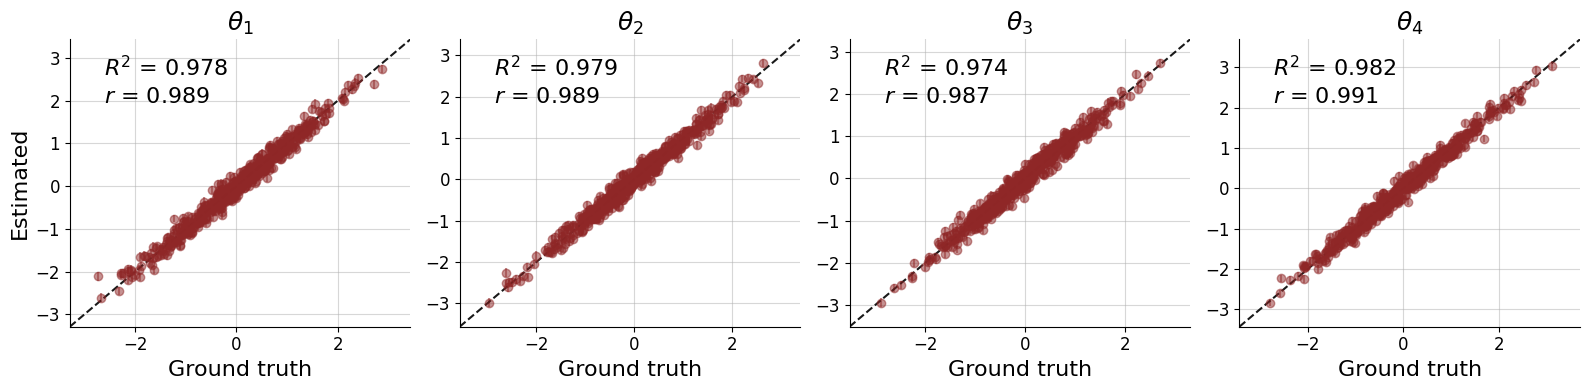

In [28]:
print("Shape of posterior samples array:", post_samples.shape)
f = bf.diagnostics.plot_recovery(post_samples, test_sims["parameters"])

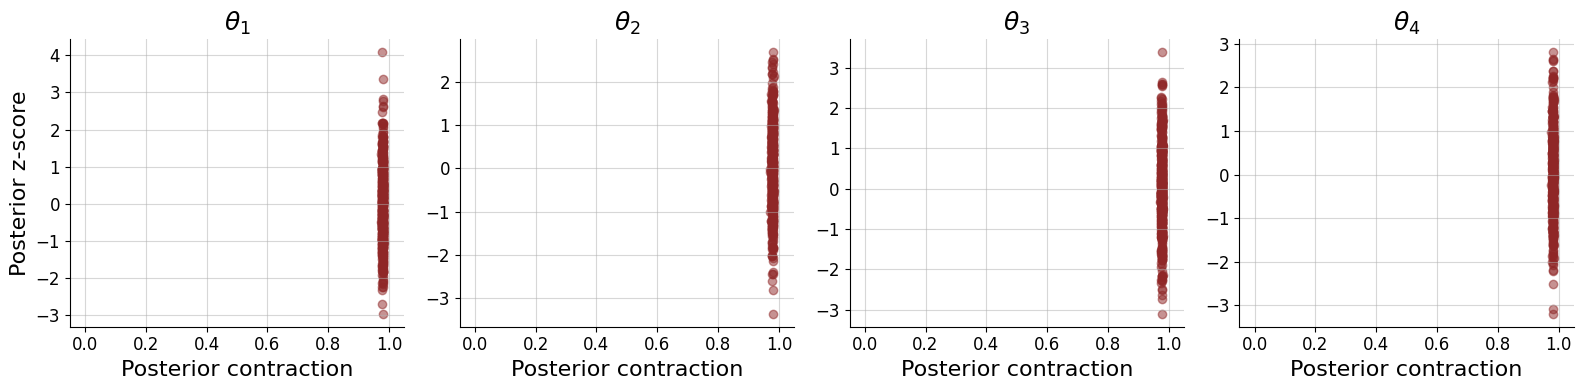

In [29]:
f = bf.diagnostics.plot_z_score_contraction(post_samples, test_sims["parameters"])